In [1]:
# 코랩에서 실행할 경우 최신 버전의 사이킷런을 설치합니다.
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
from IPython.display import Image

In [3]:
Image(url='https://git.io/JtskW', width=500) 

In [4]:
Image(url='https://git.io/Jtskl', width=500)

In [5]:
from scipy.special import comb
import math

In [6]:
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier/2.))
  probs = [comb(n_classifier, k) *
           error**k *
           (1-error)**(n_classifier-k)
           for k in range(k_start, n_classifier+1)]
  return sum(probs)

In [7]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [8]:
import numpy as np
import matplotlib.pyplot as plt

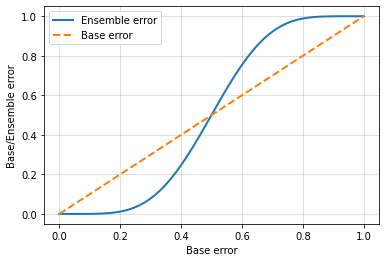

In [9]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [10]:
np.argmax(np.bincount([0,0,1],
                      weights=[0.2, 0.2, 0.6]))

1

In [11]:
np.bincount([0,0,1])

array([2, 1])

In [12]:
np.bincount([0,0,1], weights=[0.2, 0.2, 0.6])

array([0.4, 0.6])

In [13]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])

p

array([0.58, 0.42])

In [14]:
np.argmax(p)

0

In [15]:
ex = np.array([[0.4, 0.4, 0.2],
               [0.1, 0.8, 0.1],
               [0.1, 0.6, 0.3]])

q = np.average(ex,
               axis=1,
               weights=[0.2, 0.2, 0.6])

q

array([0.28, 0.24, 0.32])

In [16]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [17]:
class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
  """다수결 투표 앙상블 분류기

  매개변수
  ----------
  classifiers : 배열 타입, 크기 = [n_classifiers]
    앙상블에 사용할 분류기
  
  vote : str, {'classlabel', 'probability'}
    기본값: 'classlabel'
    'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
    'probability'면 확률 합이 가장 큰 인덱스로
    클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)

  weights : 배열 타입, 크기 = [n_classifiers]
    선택 사항, 기본값: None
    'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
    'weights=None'이면 동일하게 취급합니다

  """
  def __init__(self, classifiers, vote='classlabel', weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {
        key: value for key, value
        in _name_estimators(classifiers)
    }
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    """분류기를 학습합니다

    매개변수
    ----------
    X : {배열 타입, 희소 행렬},
      크기 = [n_samples, n_features]
      훈련 샘플 행렬

    y : 배열 타입, 크기 = [n_samples]
      타깃 클래스 레이블 벡터

    반환값
    ----------
    self : 객체

    """
    if self.vote not in ('probability', 'classlabel'):
      raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                      f"; (vote={self.vote})이 입력되었습니다.")
    if self.weights and len(self.weights) != len(self.classifiers):
      raise ValueError('분류기와 가중치 갯수는 같아야 합니다'
                      f'; 가중치 {len(self.weights)} 개, 분류기 {len(self.classifiers)} 개')
      
    # self.predict 메서드에서 np.argmax를 호출할 때
    # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
    self.labelenc_ = LabelEncoder()
    self.labelenc_.fit(y)
    self.classes_ = self.labelenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    """X에 대한 클래스 레이블을 예측합니다

    매개변수
    ----------
    X : {배열 타입, 희소 행렬},
      크기 = [n_samples, n_features]
      샘플 데이터 행렬

    반환값
    ----------
    maj_vote : 배열 타입, 크기 = [n_samples]
      예측된 클래스 레이블

    """
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else: # 'classlabel' 투표
      # clf.predict 메서드를 사용하여 결과를 모읍니다
      predictions = np.asarray([
          clf.predict(X) for clf in self.classifiers_
      ]).T

      maj_vote = np.apply_along_axis(
          lambda x:
          np.argmax(np.bincount(x,
                                weights=self.weights)),
          axis=1,
          arr=predictions
      )

    maj_vote = self.labelenc_.inverse_transform(maj_vote)
    return maj_vote
    
  def predict_proba(self, X):
    """X에 대한 클래스 확률을 예측합니다
    
    매개변수
    ----------
    X : {배열 타입, 희소 행렬},
      크기 = [n_samples, n_features]
      n_samples는 샘플의 갯수이고 n_features는 특성의 갯수인
      샘플 데이터 행렬

    반환값
    ----------
    avg_proba : 배열 타입,
      크기 = [n_samples, n_classes]
      샘플마다 가중치가 적용된 클래스의 평균 확률
    
    """
    probas = np.asarray([
        clf.predict_proba(X) for clf in self.classifiers_
    ])
    avg_proba = np.average(probas, axis=0, weights=self.weights)
    return avg_proba

  def get_params(self, deep=True):
    """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
    if not deep:
      return super(MajorityVoteClassifier, self).get_params(deep=False)
    else:
      out = self.named_classifiers.copy()
      for name, step in self.named_classifiers.items():
        for key, value in step.get_params(deep=True).items():
          out[f'{name}__{key}'] = value
      return out

In [18]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
  train_test_split(X,y,
                   test_size=0.5,
                   random_state=1,
                   stratify=y)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f"ROC AUC:{scores.mean():0.2f}, (+/- {scores.std():0.2f} [{label}]")

10-겹 교차 검증:

ROC AUC:0.92, (+/- 0.15 [Logistic regression]
ROC AUC:0.87, (+/- 0.18 [Decision tree]
ROC AUC:0.85, (+/- 0.13 [KNN]


In [20]:
# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f"ROC AUC: {scores.mean():0.2f} (+/- {scores.std():0.2f} [{label}]")

ROC AUC: 0.92 (+/- 0.15 [Logistic regression]
ROC AUC: 0.87 (+/- 0.18 [Decision tree]
ROC AUC: 0.85 (+/- 0.13 [KNN]
ROC AUC: 0.98 (+/- 0.05 [Majority voting]


In [21]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)
], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train,
                        cv=10, scoring='roc_auc')

print(f"ROC AUC: {scores['test_score'].mean():.2f} (+/- {scores['test_score'].std():.2f} [VotingClassifier]")

ROC AUC: 0.98 (+/- 0.05 [VotingClassifier]


In [22]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


In [23]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

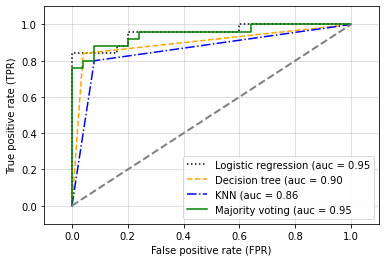

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                   y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr,
           color=clr,
           linestyle=ls,
           label=f"{label} (auc = {roc_auc:.2f}")
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")

plt.show()

In [25]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

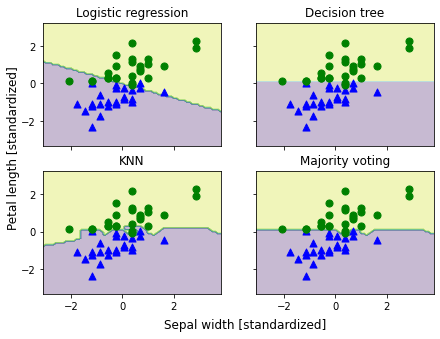

In [26]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7,5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
  clf.fit(X_train_std, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx[0], idx[1]].contourf(xx,yy,Z,alpha=.3)

  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                X_train_std[y_train==0, 1],
                                c='blue',
                                marker='^',
                                s=50)
  
  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)
  
  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

plt.show()

In [27]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [28]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline-1__clf__C': [.001, .1, 100.]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print(f"{grid.cv_results_['mean_test_score'][r]:.3f} +/- \
          {grid.cv_results_['std_test_score'][r]/2.0:.2f} \
          {grid.cv_results_['params'][r]}")

0.983 +/-           0.02           {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/-           0.02           {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/-           0.05           {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/-           0.02           {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/-           0.02           {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/-           0.05           {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [29]:
print(f"최적의 매개변수: {grid.best_params_}")
print(f"정확도: {grid.best_score_:}")

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.9833333333333334


In [30]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [31]:
mv_clf = grid.best_estimator_

In [32]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [33]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [34]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
    final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [.001, .1, 100.]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print(f"{grid.cv_results_['mean_test_score'][r]:.3f} +/- \
          {grid.cv_results_['std_test_score'][r]/2.0:.2f} \
          {grid.cv_results_['params'][r]}")

0.950 +/-           0.07           {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/-           0.02           {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/-           0.05           {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/-           0.07           {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/-           0.02           {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/-           0.05           {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [35]:
print(f"최적의 매개변수: {grid.best_params_}")
print(f"정확도: {grid.best_score_}")

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.9833333333333334


In [36]:
Image(url="https://git.io/Jtsk4", width=500)

In [37]:
Image(url="https://git.io/JtskB", width=400)

In [38]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
  train_test_split(X, y,
                   test_size=0.2,
                   random_state=1,
                   stratify=y)

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [41]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"결정 트리의 훈련 정확도/테스트 정확도 {tree_train:.3f}/{tree_test:.3f}")

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f"배깅의 훈련 정확도/테스트 정확도 {bag_train:.3f}/{bag_test:.3f}")

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


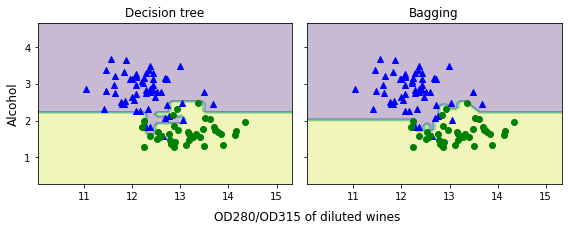

In [42]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8,3))

for idx, clf,tt in zip([0,1],
                       [tree, bag],
                       ['Decision tree', 'Bagging']):
  clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0,1],
                     c='blue', marker='^')
  
  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)

axarr[0].set_ylabel("Alcohol", fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True,
                            random_state=1)

rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

print(f"랜덤 포레스트의 훈련 정확도/테스트 정확도 {rf_train_score:.3f}/{rf_test_score:.3f}")
print(f"랜덤 포레스트의 OOB 정확도 {rf.oob_score_:.3f}")

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


In [44]:
bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)

bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print(f"배깅의 훈련 정확도/테스트 정확도 {bag_train_score:.3f}/{bag_test_score:.3f}")
print(f"배깅의 OOB 정확도 {bag.oob_score_:.3f}")

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


In [45]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [46]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f"결정 트리의 훈련 정확도/테스트 정확도 {tree_train:.3f}/{tree_test:.3f}")

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f"에이다 부스트의 훈련 정확도/테스트 정확도 {ada_train:.3f}/{ada_test:.3f}")

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다 부스트의 훈련 정확도/테스트 정확도 1.000/0.917


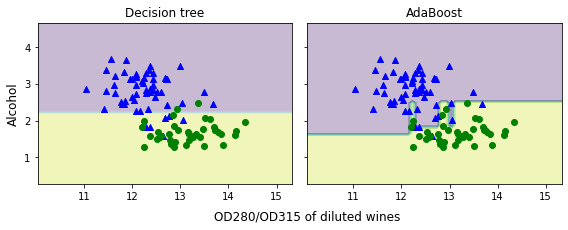

In [49]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
  clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue', marker='^')
  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green', marker='o')
  axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)

print(f"그래디언트 부스팅의 훈련 정확도/테스트 정확도 {gbrt_train_score:.3f}/{gbrt_test_score:.3f}")

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


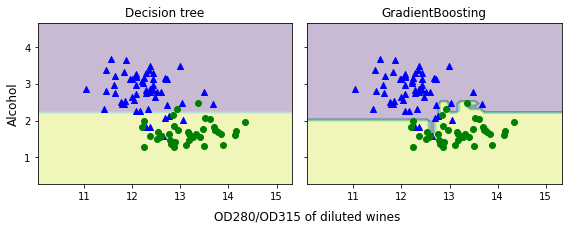

In [52]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_gradientboosting.png', dpi=300, bbox_inches='tight')
plt.show()

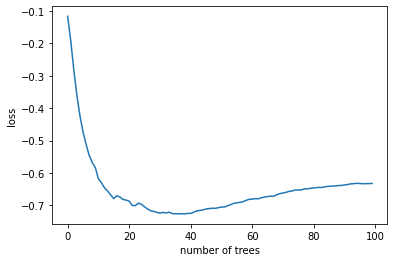

In [53]:
gbrt = GradientBoostingClassifier(n_estimators=100,
                                  subsample=0.5,
                                  random_state=1)

gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)

plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

plt.show()

In [54]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train_score = gbrt.score(X_train, y_train)
hgbc_test_score = gbrt.score(X_test, y_test)

print(f"히스토그램 기반 부스팅 훈련 정확도/테스트 정확도 {hgbc_train_score:.3f}/{hgbc_test_score:.3f}")

히스토그램 기반 부스팅 훈련 정확도/테스트 정확도 1.000/0.917


In [55]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist',
                    eval_metric='logloss',
                    use_label_encoder=False,
                    random_state=1)
xgb.fit(X_train, y_train)

xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print(f"XGBoost 훈련 정확도/테스트 정확도 {xgb_train_score:.3f}/{xgb_test_score:.3f}")

XGBoost 훈련 정확도/테스트 정확도 0.968/0.917


In [56]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print(f"LightGBM 훈련 정확도/테스트 정확도 {lgb_train_score:.3f}/{lgb_test_score:.3f}")

LightGBM 훈련 정확도/테스트 정확도 0.968/0.917
